# Implement simple NN model for classification

For this notebook, we will just use MNIST for basic analysis. The purpose is to play with a simple network in pytorch for image classification.

In [3]:
# imports
import os
import csv
import json
import random
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import HTML, display

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cpu'), 4)

# Get MNIST data
Load directly from torchvision

In [4]:
# Define transorms to apply to data
transform = [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]
batch_size_train, batch_size_test = 64, 1000

# Get training data
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/', train=True, download=True,
                transform=transforms.Compose(transform)),batch_size=batch_size_train, shuffle=True)

# Get test data
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data/', train=False, download=True,
                             transform=transforms.Compose(transform)),batch_size=batch_size_test, shuffle=True)

Let's define a simple network with just a activation(layer) for layer

In [5]:
# Set up simple network with user defined activation function and numbber of layer units
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()
        # Get activation function
        exec('self.actv = nn.%s'%actv)   
        # Define layers
        self.layers = nn.ModuleList()
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          self.layers += [nn.Linear(num_inputs, next_num_inputs)]
          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)
        
    # Make the forward pass
    def forward(self, x):
        # Flattening
        x = x.view(x.shape[0], -1)  
        
        # Apply activation function to each layer on the input 
        for layer in self.layers:
          x = self.actv(layer(x))
        x = self.out(x)
        return x

Now let's define our train() and test() functions

In [6]:
def progress(epoch, loss, epochs=100):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{epoch}'
            max='{epochs}',
            style='width: 100%'
        >
            {epoch}
        </progress>
    """.format(loss=loss, epoch=epoch, epochs=epochs))


# Define training function
def test(data_loader):
  correct = 0
  total = 0
  for (inputs, labels) in data_loader:
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return total, acc

# NOTE: this training loop only uses the training data for training the params and testing. Its based on a previous notebook where I did not have access to test data during training.
# Also this is more about working with pytorch and less about actual results. 
def train(net, criterion, optimizer,data_loader,num_epochs=1, verbose=True, training_plot=True):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  # Set to train = true
  net.train()
  training_losses = []

  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, (inputs,labels) in enumerate(data_loader, 0):

          # zero the parameter gradients
          optimizer.zero_grad()

          # Make forward pass
          outputs = net(inputs)

          # Compute Loss
          loss = criterion(outputs, labels)

          # Make backward pass and step optimizer
          loss.backward()
          optimizer.step()

          # Print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
                running_loss = 0.0
  
  # Evaluate net
  net.eval()

  train_total, train_acc = test(train_loader)

  if verbose:
    print('Accuracy on the %d training samples: %0.2f %%' % (train_total, train_acc))

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()
  
  return train_acc


In [7]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

Accuracy on the 60000 training samples: 100.00 %


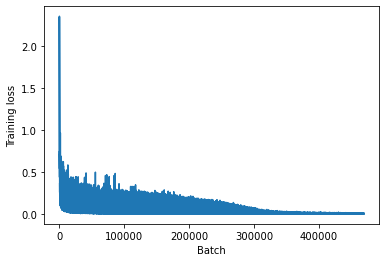

In [8]:
hidden_layers = [32]
# net = BNDeepNet().to(dev) 
net = Net('ReLU()', 1*28*28, hidden_layers, 10).to(dev) 
criterion = nn.CrossEntropyLoss()  #nn.MultiMarginLoss(margin=1.0) 
optimizer = optim.SGD(net.parameters(),lr=1e-2)#,momentum=0.5)# optim.Adam(net.parameters(), lr=1e-4)
train_acc = train(net, criterion, optimizer,train_loader,num_epochs=500)

In [11]:
test_acc = test(test_loader)
print(test_acc)

(10000, 96.51)
